In [72]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [74]:
df = pd.read_csv("cleaned_data.csv")

In [76]:
print(df.shape)
print(f"Number of rows: {df.shape[0]}")

(1669, 11)
Number of rows: 1669


C:\Users\abhin\AppData\Local\Temp\ipykernel_26568\415793634.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


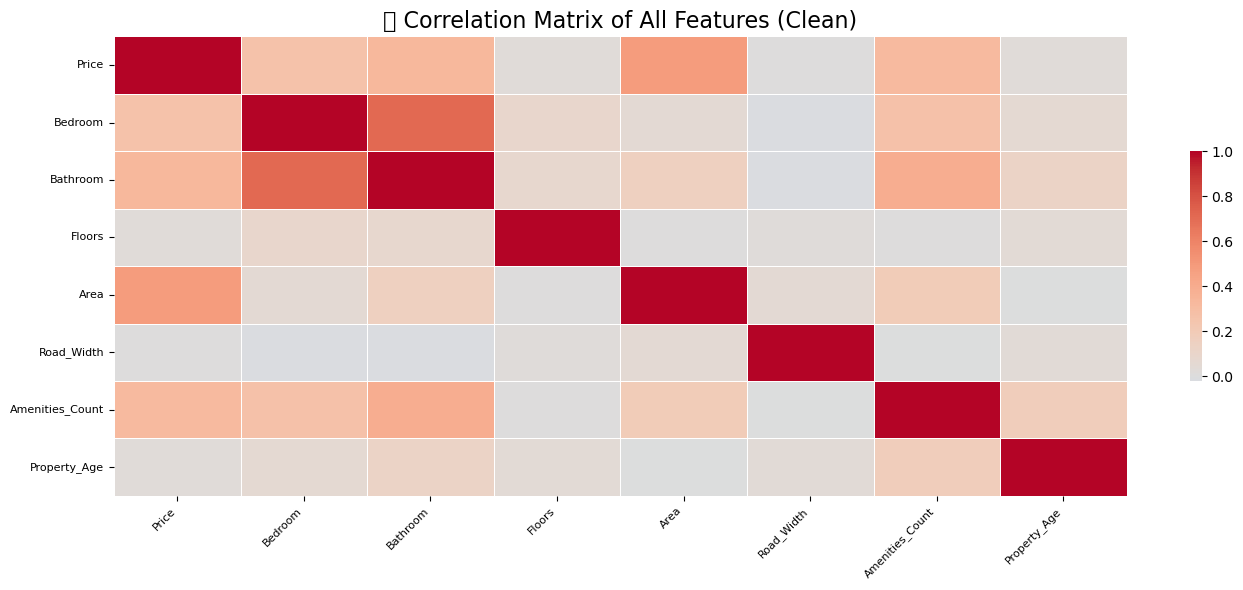

In [77]:
corr = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Draw the heatmap
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,  # we’ll annotate selected below
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title("📊 Correlation Matrix of All Features (Clean)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [79]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

# --- City Price Factors ---
city_price_factor = {
    "Kathmandu": 1.3,
    "Lalitpur": 1.2,
    "Bhaktapur": 1.1,
    "Pokhara": 1.0,
    "Chitwan": 0.9
}

# --- AREA DISTRIBUTION ---
def generate_area_distribution(n_samples=3500):
    n_small = int(0.2 * n_samples)
    n_medium = int(0.4 * n_samples)
    n_large = int(0.25 * n_samples)
    n_vlarge = n_samples - (n_small + n_medium + n_large)

    small = rng.choice([3,4,5,6,7,8], size=n_small)
    medium = rng.choice([10,12,15,20,25,30,40,50], size=n_medium)
    large = rng.choice([60,70,80,100,120], size=n_large)
    vlarge = rng.choice([150,180,200], size=n_vlarge)

    areas = np.concatenate([small, medium, large, vlarge])
    rng.shuffle(areas)
    return areas

# --- PRICE GENERATION (with city factor) ---
def generate_price(area, city, base_price=2_000_000):
    price_per_aana = base_price * (1 - 0.001 * np.log1p(area))
    city_factor = city_price_factor[city]
    return area * price_per_aana * city_factor + rng.normal(0, 5_00_000)

# --- BEDROOMS & BATHROOMS ---
def generate_bedrooms(area):
    if area <= 6: return rng.choice([2,3])
    elif area <= 20: return rng.choice([3,4,5])
    elif area <= 50: return rng.choice([4,5,6])
    else: return rng.choice([6,7,8])

def generate_bathrooms(area):
    return max(1, rng.poisson(lam=max(1, area/10)))

# --- AMENITIES ---
def generate_amenities(area):
    base = rng.integers(2,6)
    if area > 50: base += rng.integers(3,8)
    return min(base, 20)

# --- FULL DATA GENERATOR ---
def generate_synthetic_data(n_samples=3500):
    areas = generate_area_distribution(n_samples)
    data = pd.DataFrame({"Area": areas})

    # Assign city first
    data["City"] = rng.choice(
        ["Kathmandu","Lalitpur","Bhaktapur","Pokhara","Chitwan"],
        size=n_samples,
        p=[0.5,0.2,0.1,0.1,0.1]
    )

    # Price depends on area + city
    data["Price"] = [generate_price(a, c) for a, c in zip(data["Area"], data["City"])]

    # Other features
    data["Bedroom"] = data["Area"].apply(generate_bedrooms)
    data["Bathroom"] = data["Area"].apply(generate_bathrooms)
    data["Floors"] = rng.choice([1,2,3,4], size=n_samples, p=[0.1,0.4,0.4,0.1])
    data["Property_Age"] = rng.integers(1,61, size=n_samples)
    data["Amenities_Count"] = data["Area"].apply(generate_amenities)

    # Neighborhood, Road Type, Road Width
    data["Neighborhood"] = rng.choice(
        ["budhanilkantha","dhapasi","baluwatar","golfutar","kalanki"],
        size=n_samples
    )
    data["Road_Type"] = rng.choice(
        ["Paved","Gravelled","Soil Stabilized"],
        size=n_samples,
        p=[0.7,0.2,0.1]
    )
    data["Road_Width"] = rng.choice(
        [4,6,8,10,12,20],
        size=n_samples,
        p=[0.1,0.1,0.2,0.2,0.2,0.2]
    )

    return data
# --- GENERATE SYNTHETIC DATA ---
synthetic_data = generate_synthetic_data(3500)


# 2. Combine with original
augmented_df = pd.concat([df, synthetic_data], ignore_index=True)


In [80]:
print("Total rows after augmentation:", len(augmented_df))

Total rows after augmentation: 5169


In [82]:
print(augmented_df.columns)

Index(['City', 'Price', 'Bedroom', 'Bathroom', 'Floors', 'Area', 'Road_Width',
       'Road_Type', 'Neighborhood', 'Amenities_Count', 'Property_Age'],
      dtype='object')


In [83]:
# Apply one-hot encoding to only 'City' and 'Road Type'
encoded_columns = pd.get_dummies(augmented_df[['City', 'Road_Type']], dtype=int)

# Drop the original 'City' and 'Road Type' columns
augmented_df = augmented_df.drop(['City', 'Road_Type'], axis=1)

# Concatenate the one-hot encoded columns to the DataFrame
augmented_df = pd.concat([augmented_df, encoded_columns], axis=1)  


In [84]:
# Frequency encoding for Neighborhood
neigh_freq = augmented_df['Neighborhood'].value_counts(normalize=True)
augmented_df['Neighborhood_encoded'] = augmented_df['Neighborhood'].map(neigh_freq)

# Optionally drop the original Neighborhood column
augmented_df = augmented_df.drop(columns=['Neighborhood'])

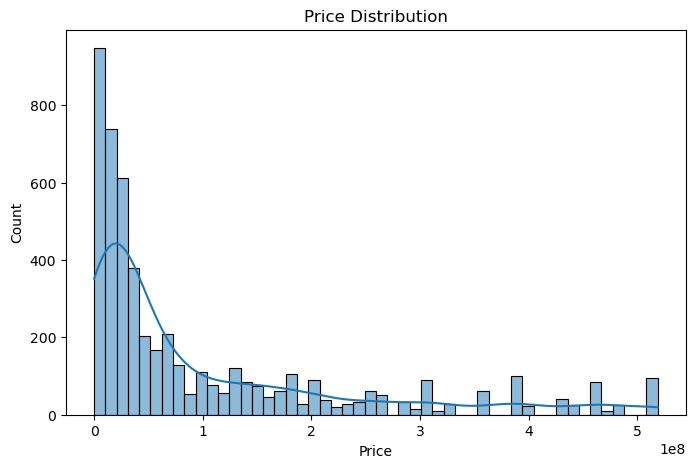

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(augmented_df["Price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()


In [87]:
from scipy.stats import skew

data = augmented_df['Price']
skewness_pandas = data.skew()

skewness_scipy = skew(data, bias= False)


skewness_scipy

1.6387668209404491

In [116]:
augmented_df.to_csv("house_data.csv", index=False)

C:\Users\abhin\AppData\Local\Temp\ipykernel_26568\576477710.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


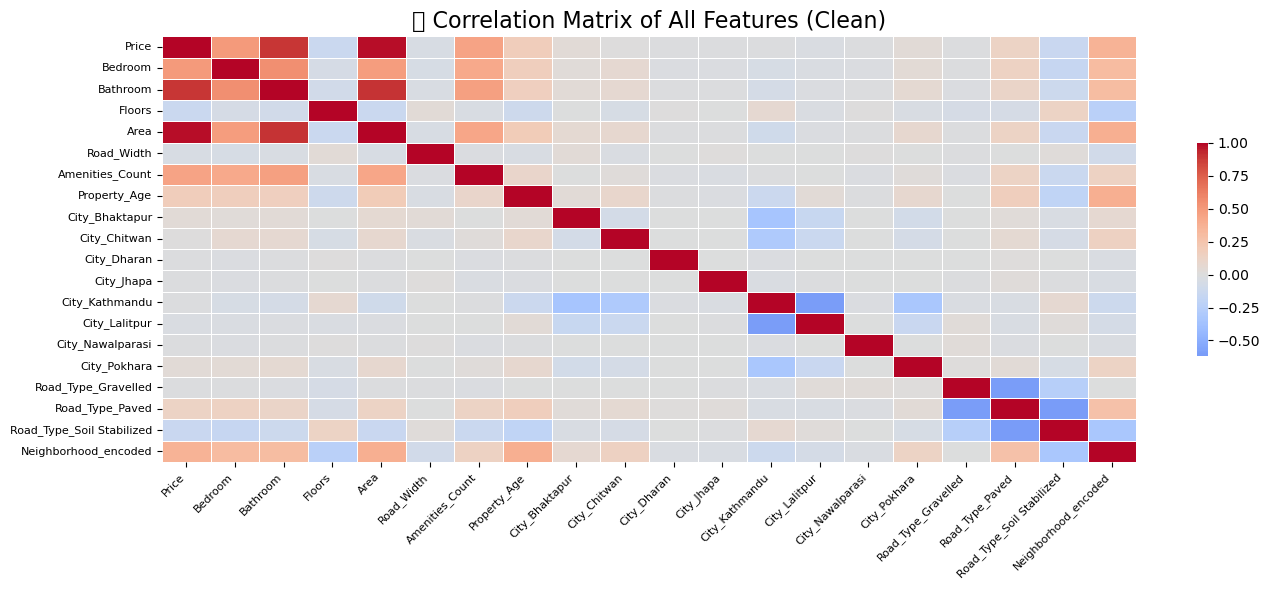

In [90]:
corr = augmented_df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Draw the heatmap
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,  # we’ll annotate selected below
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title("📊 Correlation Matrix of All Features (Clean)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()